# Experiments

In [17]:

from pathlib import Path
import pandas as pd

base_path = Path(r'G:\datasets\audioset_flac')

df_annot = pd.read_csv(base_path/'annotations.csv').set_index('ytid')
df_annot

,start_seconds,end_seconds,positive_labels,dataset_split,plausible_superclass,check_status,file_path
ytid,,,,,,,
--4gqARaEJE,0.0,10.0,"""/m/068hy,/m/07q6cd_,/m/0bt9lr,/m/0jbk""",eval,noise,good,good\eval\noise\--4gqARaEJE.flac
--BfvyPmVMo,20.0,30.0,"""/m/03l9g""",eval,noise,good,good\eval\noise\--BfvyPmVMo.flac
-0Gj8-vB1q4,30.0,40.0,"""/m/0140xf,/m/02cjck,/m/04rlf""",eval,music,good,good\eval\music\-0Gj8-vB1q4.flac
-0RWZT-miFs,420.0,430.0,"""/m/03v3yw,/m/0k4j""",eval,noise,bad,bad\eval\noise\-0RWZT-miFs.flac
-0YUDn-1yII,30.0,40.0,"""/m/02cjck,/m/04rlf""",eval,music,bad,bad\eval\music\-0YUDn-1yII.flac
...,...,...,...,...,...,...,...
zzfcNds_9_g,30.0,40.0,"""/m/09x0r""",train_unbalanced,speech,unchecked,unchecked\train_unbalanced\speech\zzfcNds_9_g....
zzlfP-snUeY,10.0,20.0,"""/m/02mk9,/m/07pb8fc,/m/07yv9,/t/dd00129""",train_unbalanced,noise,unchecked,unchecked\train_unbalanced\noise\zzlfP-snUeY.flac
zznhOWygvlo,20.0,30.0,"""/m/09x0r""",train_unbalanced,speech,unchecked,unchecked\train_unbalanced\speech\zznhOWygvlo....


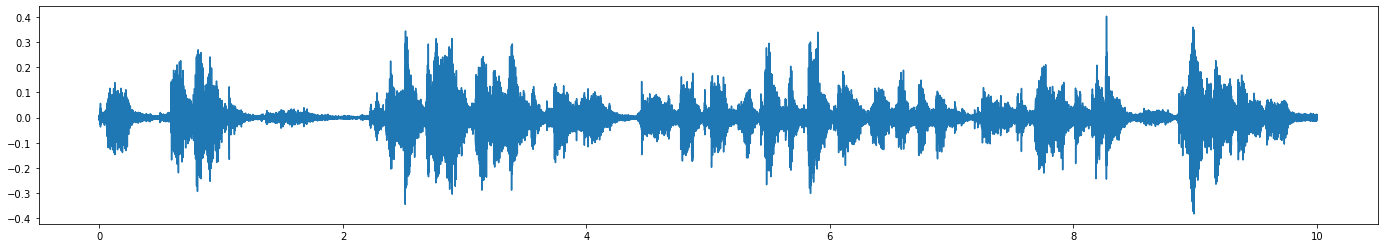

In [19]:
import librosa as rosa
import numpy as np
import matplotlib.pyplot as plt


example_file = base_path/(df_annot.loc['zzfcNds_9_g', 'file_path'])
example,sampling_rate = rosa.load(example_file)

plt.figure(figsize=(24,4))
plt.plot(np.arange(len(example))/sampling_rate, example)

In [20]:
import sounddevice as sd
sd.play(example, sampling_rate)

## Silence Removal

In [21]:
win_len = .025
win_step = .010

split_inds = rosa.effects.split(example, top_db=20, frame_length=int(win_len*sampling_rate), 
                            hop_length=int(win_step*sampling_rate))
split_inds

array([[  1100,   5940],
       [ 12760,  25080],
       [ 49280,  49500],
       [ 49940,  51040],
       [ 51920,  80080],
       [ 82060,  91960],
       [ 92180,  92620],
       [ 98120, 103620],
       [105160, 108900],
       [109560, 110220],
       [110660, 114840],
       [115500, 118800],
       [119680, 126940],
       [127380, 132440],
       [133100, 138380],
       [139700, 143440],
       [143880, 147620],
       [148060, 150480],
       [151360, 153780],
       [154880, 155320],
       [159720, 165000],
       [166100, 167860],
       [169400, 179080],
       [179740, 185460],
       [195360, 210760],
       [211200, 215600]])

In [7]:

def remove_silence(audio, sampling_rate, top_db=20, win_len=.025, win_step=.010, return_silence=False):
    split_inds = rosa.effects.split(audio, top_db=top_db, frame_length=int(win_len*sampling_rate), 
                                    hop_length=int(win_step*sampling_rate))

    isig = np.concatenate(list(np.arange(*v) for v in split_inds), 0)
    signal = example[isig]
    if not return_silence:
        return signal
    else:
        isil = np.setdiff1d(np.arange(len(example)), isig)
        silence = example[isil]
        return signal, silence

In [8]:
import sounddevice as sd

signal, silence = remove_silence(example, sampling_rate, top_db=20, win_len=.025, win_step=.010, return_silence=True)
sd.play(signal, sampling_rate)

In [9]:
sd.play(silence, sampling_rate)

In [22]:
import tf_mel_features as tmf

specgram = tmf.log_spectrogram(example, sampling_rate, win_len, win_step, 1024)
# specgram


<tf.Tensor: shape=(1001, 513), dtype=float32, numpy=
array([[-19.397255 , -17.439198 , -18.568085 , ..., -12.514088 ,
        -15.869693 , -12.236956 ],
       [-17.207533 , -16.627064 , -16.541395 , ..., -13.541838 ,
        -13.448367 , -13.00718  ],
       [-15.282794 , -18.875217 , -15.2586355, ..., -15.089737 ,
        -13.081764 , -12.181342 ],
       ...,
       [-20.420721 , -18.86477  , -17.383627 , ..., -16.56867  ,
        -16.568958 , -24.259636 ],
       [-17.005627 , -17.302351 , -16.36458  , ..., -20.402042 ,
        -19.463219 , -16.793377 ],
       [-16.136013 , -15.729778 , -16.12655  , ..., -16.913345 ,
        -15.907838 , -17.068846 ]], dtype=float32)>

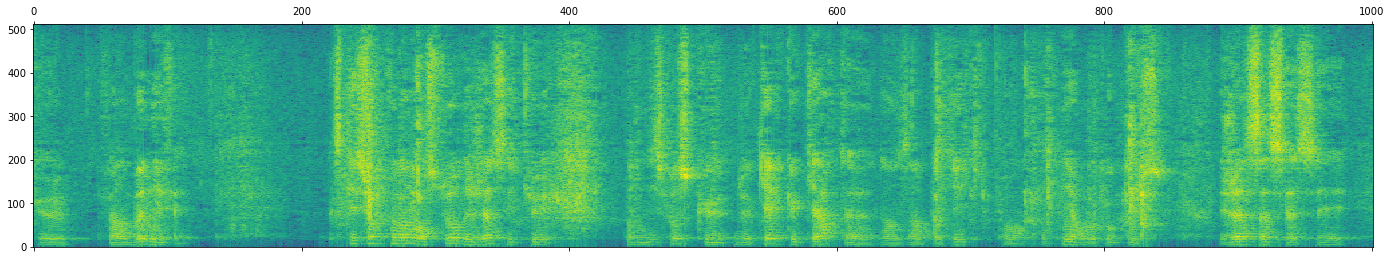

In [23]:
plt.figure(1, figsize=(24,4))
plt.matshow(specgram.numpy().T, origin='lower', aspect='auto', fignum=1)

In [27]:
import tensorflow as tf

example_tf, fs,  = tf.audio.decode_wav(tf.io.read_file(str(example_file)))
example_tf = tf.reduce_mean(example_tf, axis=1)

In [28]:
sd.play(example_tf.numpy(), fs.numpy())


In [27]:
import python_speech_features as psf
out = psf.logfbank(signal, sampling_rate, win_len, win_step, nfilt=64,nfft=1024)
out

array([[-17.5075946 , -14.75986727, -11.09337624, ...,  -9.72573012,
         -9.766893  , -10.27625   ],
       [-14.06681339, -13.65016684,  -9.98181362, ...,  -9.54635042,
         -9.00012267,  -9.65575927],
       [-12.03398393, -11.47027047, -10.1081625 , ...,  -9.59564498,
         -8.96599173,  -9.7326888 ],
       ...,
       [-14.43380095, -13.18064404, -10.09842937, ..., -10.15199999,
        -12.37731242, -11.27338898],
       [-17.25107277, -13.77531496, -10.34073929, ..., -10.27575817,
        -11.84050816, -11.83690108],
       [-14.41963744, -13.8655378 , -11.02547926, ..., -10.86217386,
        -11.78278024, -11.80774136]])

In [8]:
mfb = tmf.log_mfb(signal, sampling_rate, winlen=win_len, winstep=win_step, nfilt=64, nfft=1024)
mfb

(<tf.Tensor: shape=(667, 64), dtype=float32, numpy=
 array([[-16.000975 , -13.265785 , -10.699541 , ...,  -9.737987 ,
          -9.761899 , -10.2606535],
        [-15.02408  , -12.160072 ,  -9.951225 , ...,  -9.622354 ,
          -8.974079 ,  -9.524381 ],
        [-11.617904 , -10.880156 , -10.495432 , ...,  -9.57001  ,
          -8.926115 ,  -9.71046  ],
        ...,
        [-14.301755 , -11.396546 , -10.1852865, ..., -10.139657 ,
         -12.215765 , -11.25727  ],
        [-14.611809 , -11.862274 , -10.263132 , ..., -10.267136 ,
         -11.822679 , -11.8412895],
        [-15.706695 , -12.35506  , -11.28259  , ..., -10.879179 ,
         -11.802646 , -11.799266 ]], dtype=float32)>,
 <tf.Tensor: shape=(667,), dtype=float32, numpy=
 array([0.01271671, 0.0145805 , 0.01569314, 0.01785268, 0.01895568,
        0.02215201, 0.02631531, 0.02397384, 0.02157346, 0.02285455,
        0.02274958, 0.02365788, 0.02221032, 0.01757525, 0.01649213,
        0.01568514, 0.01361276, 0.00834204, 0.004730

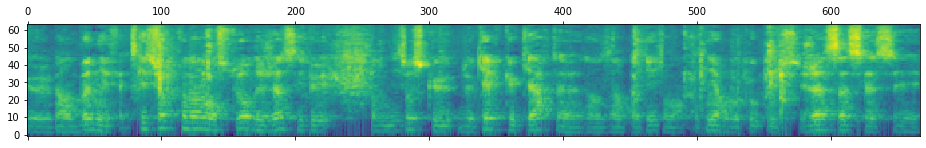

In [10]:
plt.matshow(mfb[0].numpy().T, origin='lower', aspect='auto')

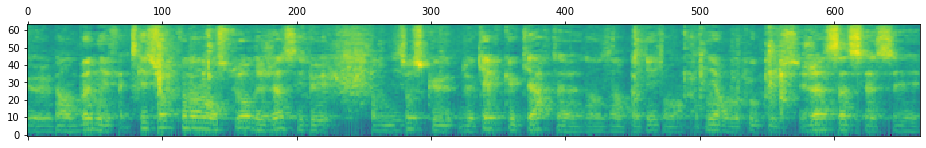

In [11]:
plt.matshow(out.T, origin='lower', aspect='auto')

In [ ]:
out.dtype

In [21]:
import python_speech_features as psf

def normalize_volume(sig, fs, winlen=.200, winstep=.010):
    frms = psf.sigproc.framesig(sig, winlen*fs, winstep*fs)
    frms = frms/frms.std(axis=-1, keepdims=True)
    sig = psf.sigproc.deframesig(frms, siglen=len(sig), 
                                  frame_len=winlen*fs, frame_step= winstep*fs)
    return sig

In [24]:
normalized_signal = normalize_volume(signal, sampling_rate)
sd.play(normalized_signal, sampling_rate)

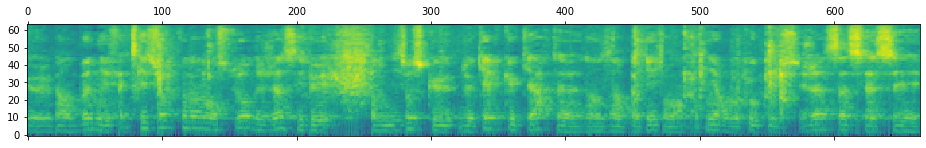

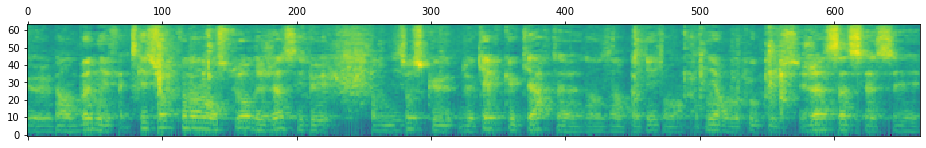

In [28]:
out_norm = psf.logfbank(normalized_signal, sampling_rate, win_len, win_step, nfilt=64,nfft=1024)
plt.matshow(out_norm.T, origin='lower', aspect='auto')
plt.matshow(out.T, origin='lower', aspect='auto')

In [37]:
sampling_rate

22050

# Process Files

In [13]:

from pathlib import Path
import pandas as pd

base_path = Path(r'G:\datasets\audioset_flac')
feat_path = Path(r'G:\datasets\audioset_features_flac\logmfb')

df_annot = pd.read_csv(base_path/'annotations.csv').set_index('ytid')
df_annot

,start_seconds,end_seconds,positive_labels,dataset_split,plausible_superclass,check_status,file_path
ytid,,,,,,,
--4gqARaEJE,0.0,10.0,"""/m/068hy,/m/07q6cd_,/m/0bt9lr,/m/0jbk""",eval,noise,good,good\eval\noise\--4gqARaEJE.flac
--BfvyPmVMo,20.0,30.0,"""/m/03l9g""",eval,noise,good,good\eval\noise\--BfvyPmVMo.flac
-0Gj8-vB1q4,30.0,40.0,"""/m/0140xf,/m/02cjck,/m/04rlf""",eval,music,good,good\eval\music\-0Gj8-vB1q4.flac
-0RWZT-miFs,420.0,430.0,"""/m/03v3yw,/m/0k4j""",eval,noise,bad,bad\eval\noise\-0RWZT-miFs.flac
-0YUDn-1yII,30.0,40.0,"""/m/02cjck,/m/04rlf""",eval,music,bad,bad\eval\music\-0YUDn-1yII.flac
...,...,...,...,...,...,...,...
zzfcNds_9_g,30.0,40.0,"""/m/09x0r""",train_unbalanced,speech,unchecked,unchecked\train_unbalanced\speech\zzfcNds_9_g....
zzlfP-snUeY,10.0,20.0,"""/m/02mk9,/m/07pb8fc,/m/07yv9,/t/dd00129""",train_unbalanced,noise,unchecked,unchecked\train_unbalanced\noise\zzlfP-snUeY.flac
zznhOWygvlo,20.0,30.0,"""/m/09x0r""",train_unbalanced,speech,unchecked,unchecked\train_unbalanced\speech\zznhOWygvlo....


In [16]:
import librosa as rosa
import python_speech_features as psf
import numpy as np



def load_audio(file_path):
    audio, sampling_rate = rosa.load(file_path)
    return audio, sampling_rate

def remove_silence(audio, sampling_rate=22050, top_db=20, win_len=.025, win_step=.010, return_silence=False):
    split_inds = rosa.effects.split(audio, top_db=top_db, frame_length=int(win_len*sampling_rate), 
                                    hop_length=int(win_step*sampling_rate))

    isig = np.concatenate(list(np.arange(*v) for v in split_inds), 0)
    signal = audio[isig]
    if not return_silence:
        return signal
    else:
        isil = np.setdiff1d(np.arange(len(audio)), isig)
        silence = audio[isil]
        return signal, silence

def normalize_volume(sig, sampling_rate=22050, win_len=.200, win_step=.010):
    frms = psf.sigproc.framesig(sig, win_len*sampling_rate, win_step*sampling_rate)
    frms = frms/frms.std(axis=-1, keepdims=True)
    sig = psf.sigproc.deframesig(frms, siglen=len(sig), 
                                  frame_len=win_len*sampling_rate, frame_step= win_step*sampling_rate)
    return sig


def get_features(audio, sampling_rate=22050, win_len=.025, win_step=.010, nfilt=64, nfft=1024):
    mfb = psf.logfbank(audio, sampling_rate, win_len, win_step, nfilt, nfft)
    return mfb


def process_file(file_path, win_len=.025, win_step=.010, nfilt=64, nfft=1024, dtype=np.float32):
    audio, sampling_rate = load_audio(file_path)
    signal = remove_silence(audio, sampling_rate)
    normalized_signal = normalize_volume(signal, sampling_rate)
    mfb = get_features(normalized_signal, sampling_rate, win_len, win_step, nfilt, nfft).astype(dtype)
    return mfb


In [8]:

example_file = base_path/(df_annot.loc['zzfcNds_9_g', 'file_path'])
processed_example = process_file(example_file)
processed_example

array([[-11.380216 ,  -8.6345005,  -4.962892 , ...,  -3.592831 ,
         -3.6337779,  -4.1478534],
       [ -7.922949 ,  -7.509925 ,  -3.8461795, ...,  -3.408512 ,
         -2.8608627,  -3.5184932],
       [ -5.901104 ,  -5.338432 ,  -3.9621205, ...,  -3.4525518,
         -2.8212578,  -3.5901484],
       ...,
       [ -7.343739 ,  -6.090133 ,  -3.0073013, ...,  -3.0571961,
         -5.281146 ,  -4.17981  ],
       [-10.181625 ,  -6.683656 ,  -3.2473793, ...,  -3.1807716,
         -4.7495537,  -4.7511263],
       [ -7.32702  ,  -6.7718787,  -3.9296908, ...,  -3.7659073,
         -4.694586 ,  -4.7238646]], dtype=float32)

In [10]:
from tqdm import tqdm

df_selected = df_annot.loc[df_annot.check_status == 'good']
df_annot['logmfb_path'] = ''

for ytid, row in tqdm(df_selected.iterrows(), total=len(df_selected)):
    file_path = base_path/row.file_path
    
    features = process_file(file_path)
    
    dest_path = feat_path/row.check_status/row.dataset_split/row.plausible_superclass/(ytid+'.npy')
    
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    np.save(str(dest_path), features)
    
    df_annot.loc[ytid, 'logmfb_path'] = str(dest_path)

100%|██████████| 12064/12064 [44:57<00:00,  4.47it/s]


In [12]:
df_annot.loc[:,['logmfb_path']].reset_index().to_csv(feat_path/'logmfb_path.csv', index=False)